# Regression with a Mohs Hardness Dataset
In this notebook, we will build a regression model to predict the Mohs hardness. You can find the competition page [here](https://www.kaggle.com/competitions/playground-series-s3e25).

<div align="center">
<img src="https://www.kaggle.com/competitions/60892/images/header" />
</div>

## 1. Importing Libraries

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error

import warnings

### Configuration

In [119]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [120]:
df = pd.read_csv('train.csv', index_col='id')

In [121]:
df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [123]:
df.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [124]:
df.shape

(10407, 12)

## 3. Exploratory Data Analysis

In [125]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840
zaratio_Average,10407.0,0.493349,0.063080,0.0,0.476196,0.488550,0.496070,0.825990


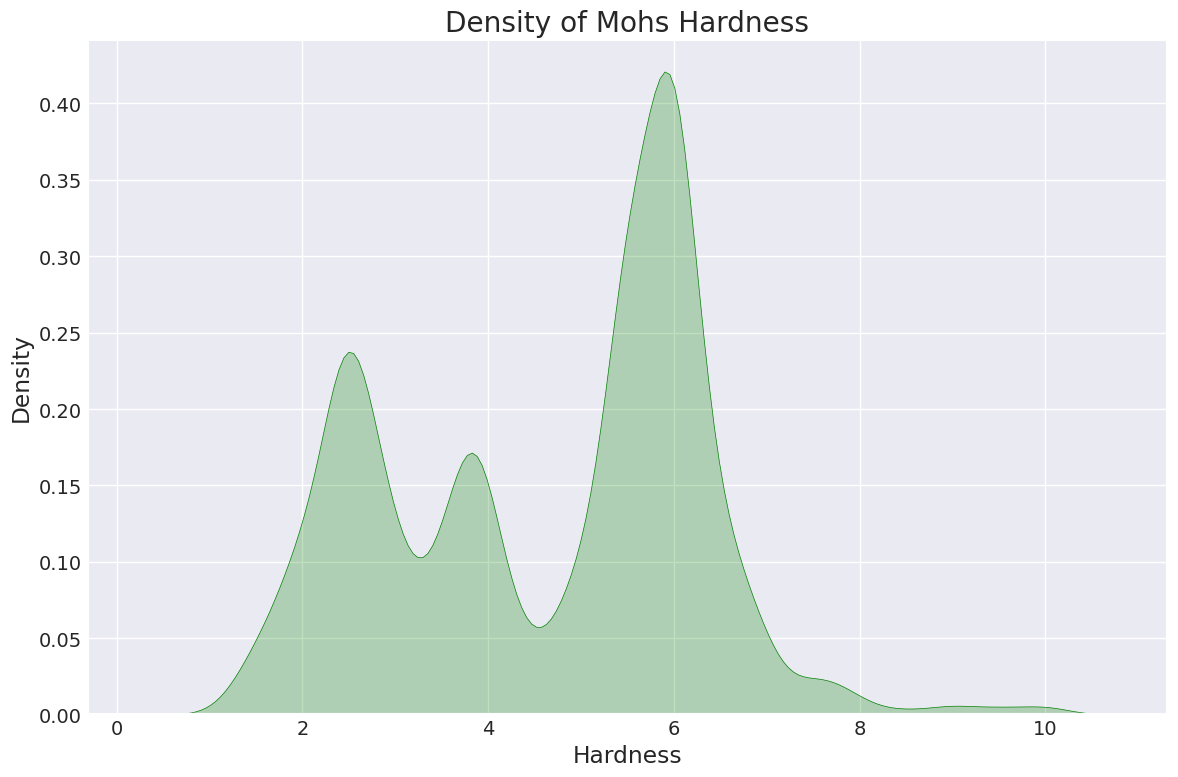

In [126]:
sns.kdeplot(df['Hardness'], fill=True, color='g')
plt.title('Density of Mohs Hardness')
plt.tight_layout()

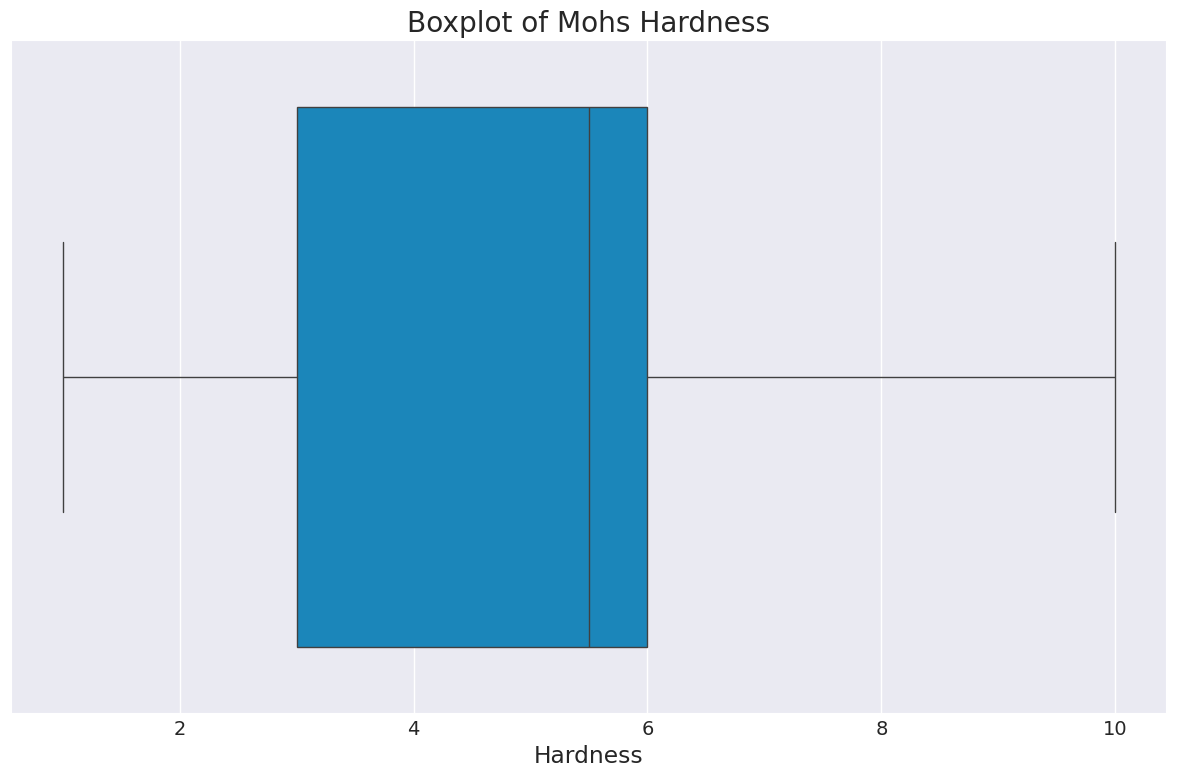

In [127]:
sns.boxplot(df['Hardness'], orient='h')
plt.title('Boxplot of Mohs Hardness')
plt.tight_layout()

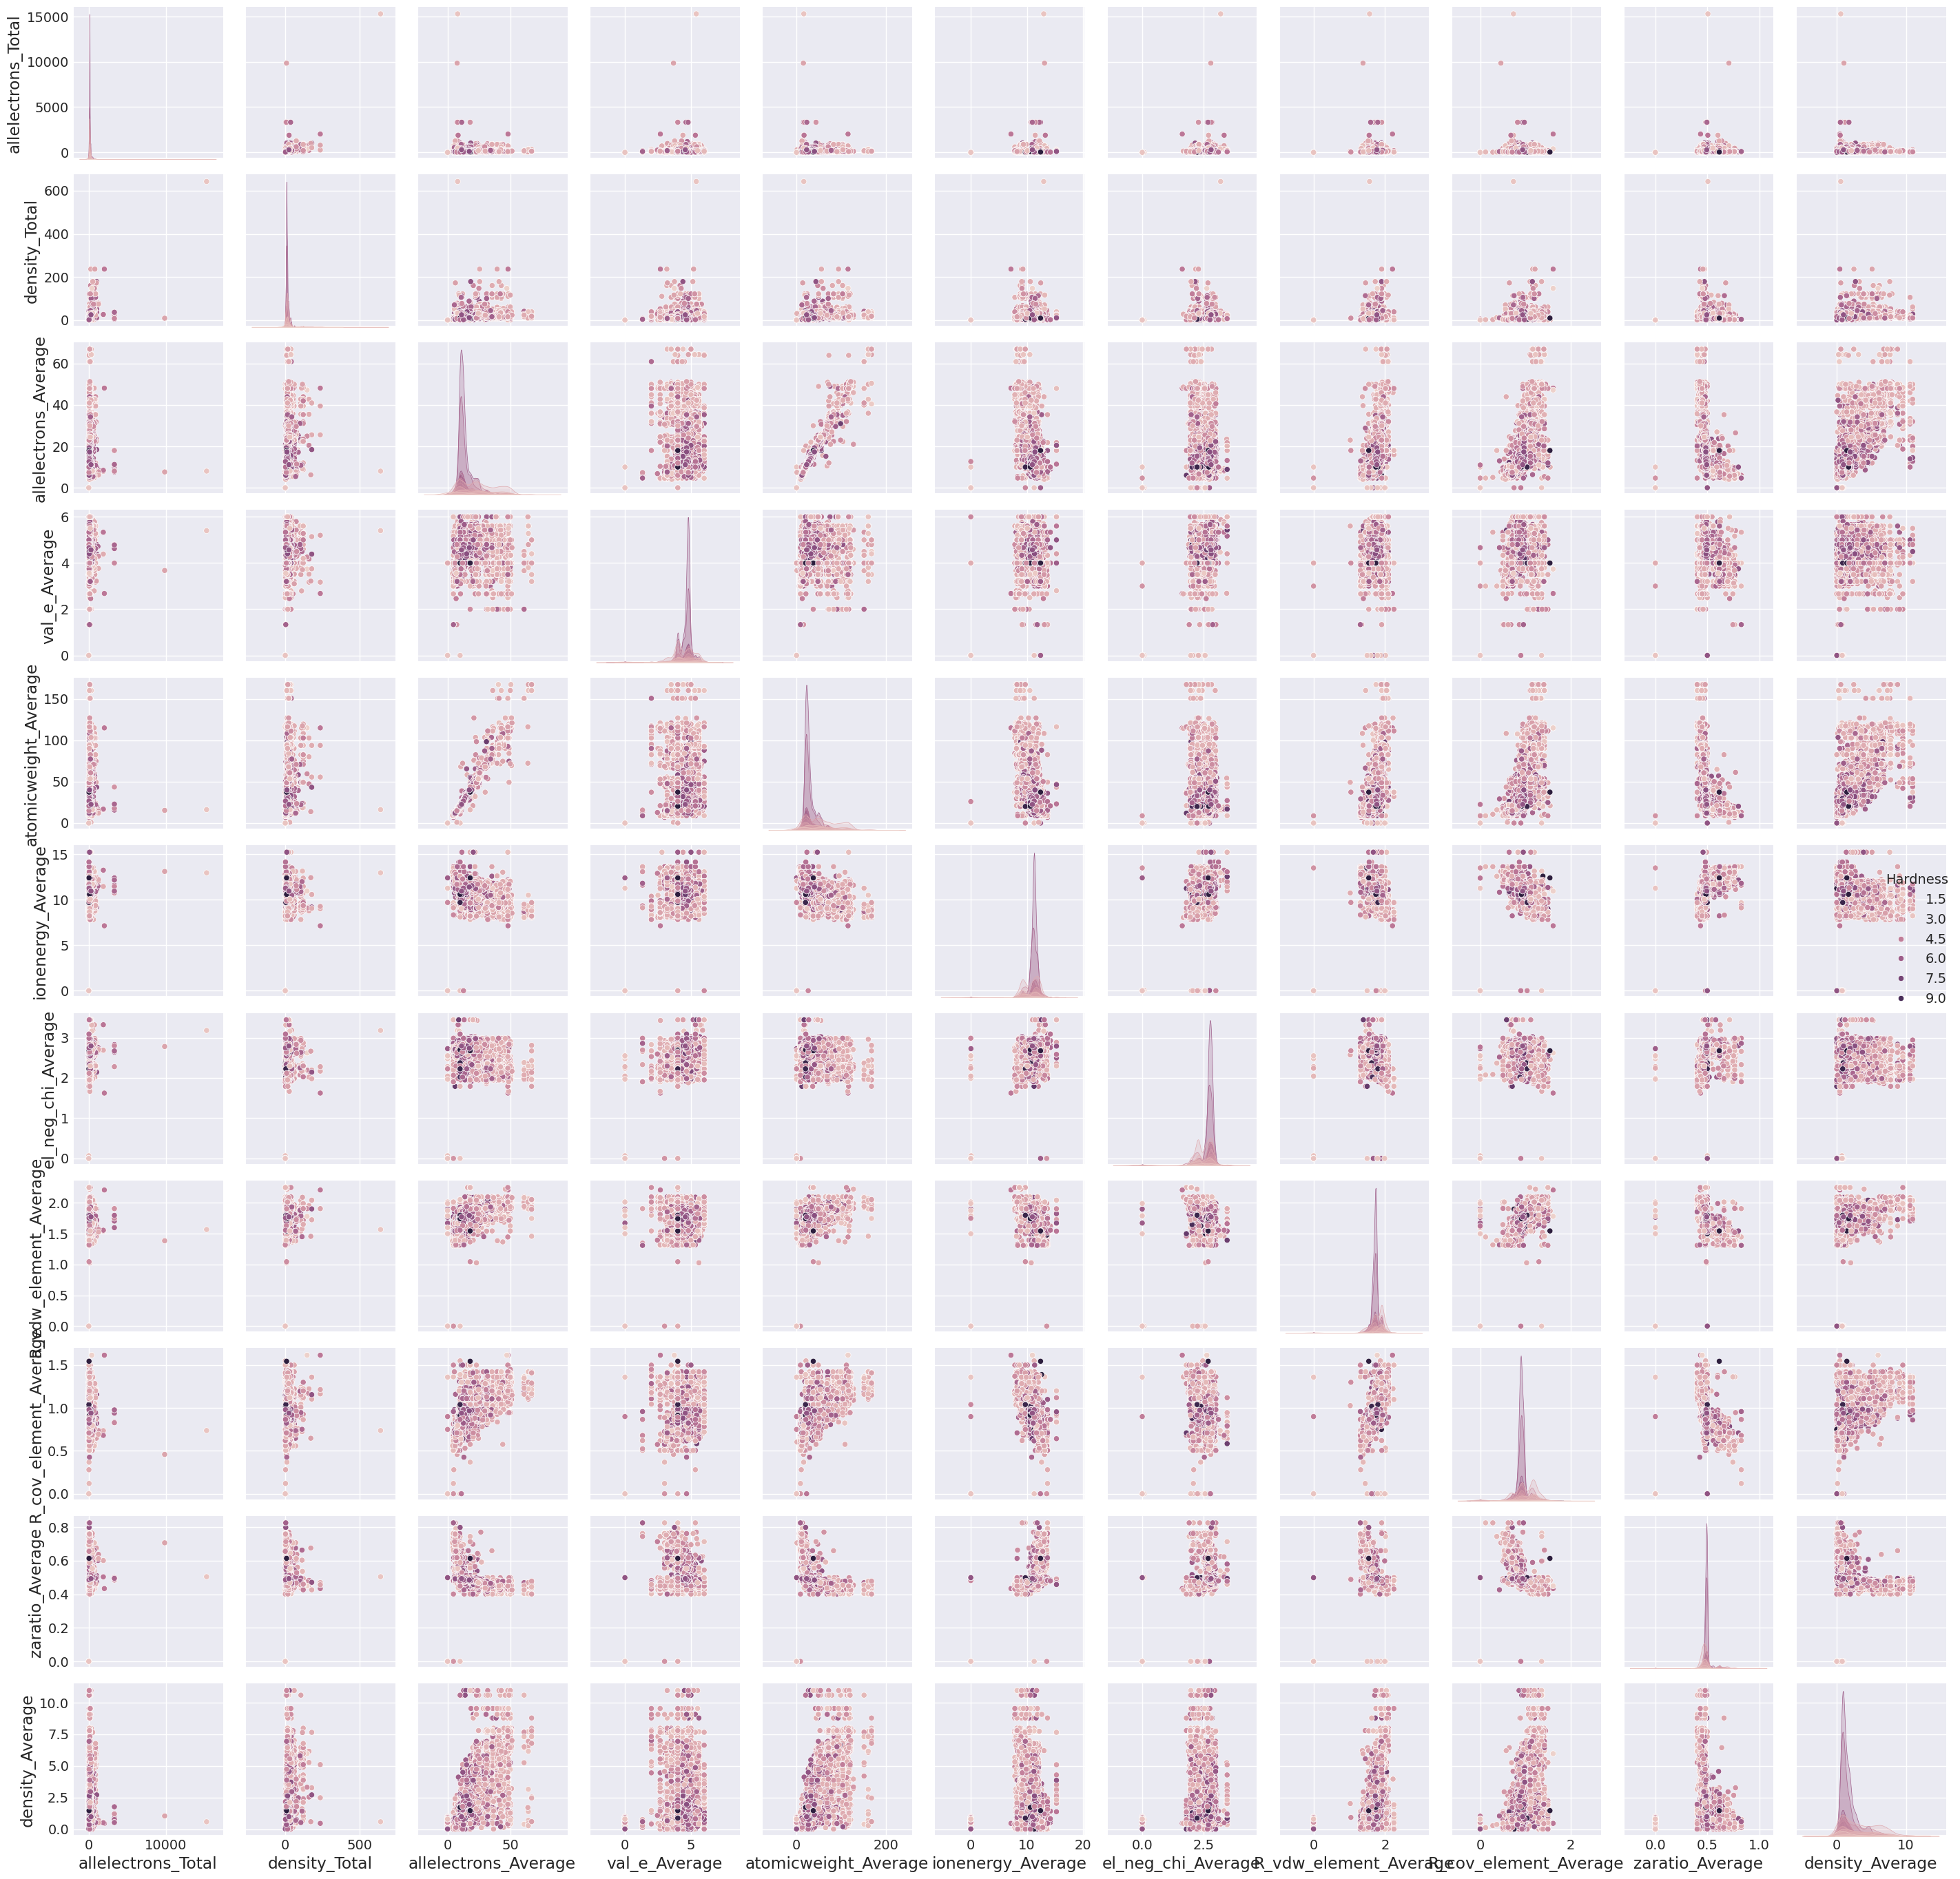

In [128]:
sns.pairplot(df, hue='Hardness')
plt.tight_layout()

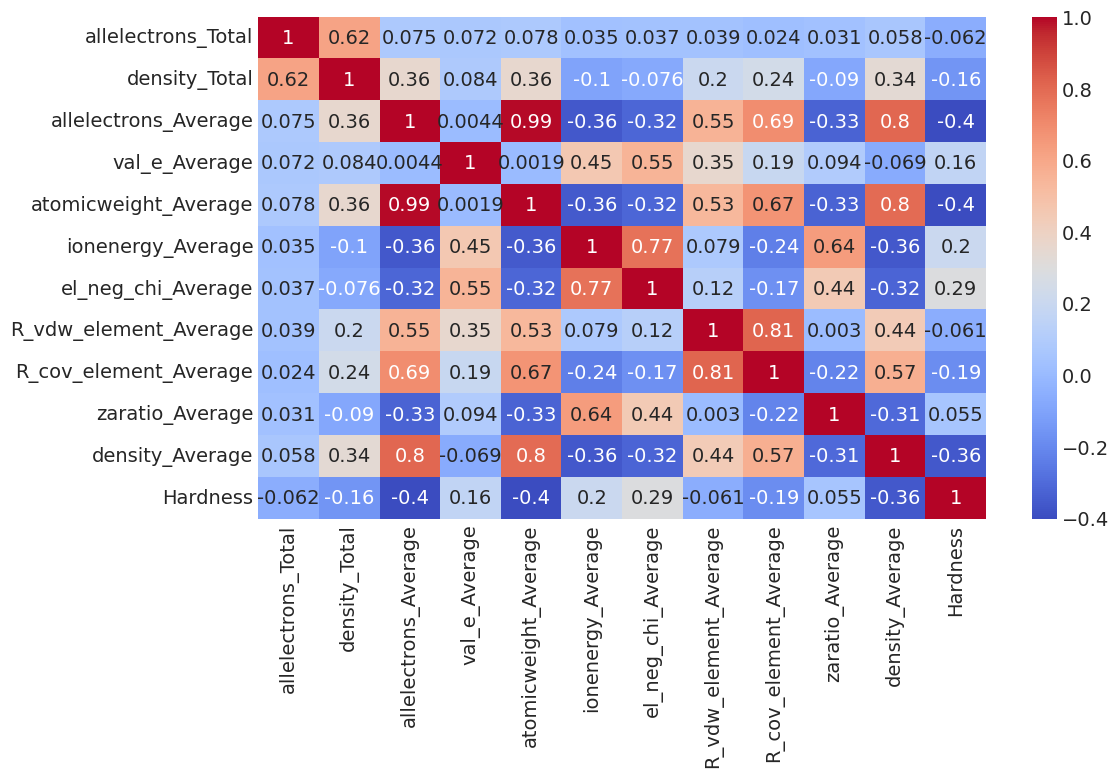

In [129]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()

In [130]:
abs(df.corr()['Hardness']).sort_values(ascending=False)

Hardness                 1.000000
atomicweight_Average     0.402948
allelectrons_Average     0.400496
density_Average          0.360780
el_neg_chi_Average       0.290352
ionenergy_Average        0.203203
R_cov_element_Average    0.189111
val_e_Average            0.161715
density_Total            0.161524
allelectrons_Total       0.061687
R_vdw_element_Average    0.061402
zaratio_Average          0.055248
Name: Hardness, dtype: float64

## 4. Data Preprocessing

In [131]:
x = df.drop(columns=['Hardness', 'zaratio_Average', 'R_vdw_element_Average', 'allelectrons_Total'])
y = df[['Hardness']]

In [132]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [133]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [134]:
x_train.shape

(8325, 8)

## 5. Model Training & Evaluation

In [135]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "LightGBM": lgb.LGBMRegressor(verbose=0),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}


def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [136]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/10 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training KNeighborsRegressor model...
Training LightGBM model...
Training XGBoost model...
Training GradientBoostingRegressor model...
Training RandomForestRegressor model...


,Model,R2_Score,MSE,RMSE
0,LightGBM,0.456985,1.475953,1.214888
1,GradientBoostingRegressor,0.443230,1.513340,1.230179
2,RandomForestRegressor,0.420351,1.575528,1.255200
3,XGBoost,0.401061,1.627960,1.275916
4,KNeighborsRegressor,0.309043,1.878070,1.370427
5,LinearRegression,0.200647,2.172700,1.474008
6,Ridge,0.200620,2.172774,1.474033
7,Lasso,-0.000084,2.718301,1.648727
8,ExtraTreeRegressor,-0.119646,3.043278,1.744499
9,DecisionTreeRegressor,-0.130274,3.072167,1.752760


### Hyperparameter Tuning

In [137]:
# Hyperparameters for grid search
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5],
}

In [138]:
%%time
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(verbose=-1),
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search.fit(x_train, y_train)

CPU times: user 1min 24s, sys: 408 ms, total: 1min 24s
Wall time: 20.2 s


,estimator,LGBMRegressor(verbose=-1)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5], 'n_estimators': [50, 100, ...], 'num_leaves': [31, 50, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [139]:
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 31}

In [140]:
grid_search.best_score_

np.float64(0.4667188245968033)

## 6. Building the Pipeline, Saving the Model & Making Submission

In [141]:
preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), x.columns.tolist())
])

In [142]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(verbose=-1, **grid_search.best_params_))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [143]:
r2_score(y, pipeline.predict(x))

0.6379306548433302

In [144]:
joblib.dump(pipeline, 'mohs_hardness_regressor.pkl')

['mohs_hardness_regressor.pkl']

### Making Submission file

In [145]:
test = pd.read_csv('test.csv', index_col='id')

In [146]:
pred = pipeline.predict(test)

In [147]:
submission = pd.DataFrame({
    'id': test.index,
    'Hardness': pred
})
submission.head()

,id,Hardness
0,10407,3.246297
1,10408,2.917865
2,10409,5.713313
3,10410,4.060380
4,10411,5.562447


In [148]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
In this notebook, we:
- Loaded and explored the Mohs hardness data
- Preprocessed features (MinMax scaling) and created a train/test split
- Compared several regressors and tuned LightGBM with cross-validation
- Built a pipeline, saved the model, and created a submission file

Key insights:
- Tuned LightGBM achieved the strongest R² among tested models
- Basic scaling and removing weak features improved stability and accuracy